# Homework #4 - LSTM을 이용한 암호화폐 가격 예측

---
## Part 1: 공통 설정 및 모듈 정의

In [2]:
# 라이브러리 임포트
import os
import torch
import pandas as pd
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
from string import Template
import wandb
import matplotlib.pyplot as plt

# Jupyter 노트북에서 그래프를 인라인으로 표시
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA available: True


### 1.1 Config 클래스 정의

argparse 대신 Config 클래스를 사용하여 노트북에서 직접 파라미터를 관리합니다.
각 문제에서 필요한 파라미터만 오버라이드하여 사용합니다.

In [3]:
class Config:
    """
    학습 설정 클래스
    - 문제 1: 기본값 사용 (수업 자료)
    - 문제 2-4: 필요한 파라미터만 직접 변경
    """
    # WandB 설정
    wandb_enabled = True

    # 학습 파라미터
    batch_size = 2048
    epochs = 10000
    learning_rate = 1e-4
    weight_decay = 0.0

    # 검증 및 조기 종료 설정
    validation_intervals = 30
    early_stop_patience = 30
    early_stop_delta = 0.000001

    # LSTM 모델 구조 파라미터
    lstm_hidden_size = 128
    lstm_num_layers = 2
    fcn_num_layers = 1
    dropout_rate = 0.0

    # 데이터 설정 (문제 1 기본값)
    sequence_size = 10
    validation_size = 100
    test_size = 10

    # 추가 설정
    use_next_open = False  # 문제 3에서 True로 변경
    model_type = "lstm"    # 문제 4에서 "self_attention"으로 변경

    # 파일 경로
    csv_path = "BTC_KRW_2025_11_30.csv"
    checkpoint_path = "./checkpoints"


def print_config():
    """현재 설정 출력"""
    print("="*60)
    print("[현재 설정]")
    print("="*60)
    print(f"\n[학습 파라미터]")
    print(f"  - Batch Size: {Config.batch_size}")
    print(f"  - Learning Rate: {Config.learning_rate}")
    print(f"  - Epochs: {Config.epochs}")
    print(f"  - Weight Decay: {Config.weight_decay}")
    print(f"\n[모델 구조]")
    print(f"  - Model Type: {Config.model_type}")
    print(f"  - LSTM Hidden Size: {Config.lstm_hidden_size}")
    print(f"  - LSTM Num Layers: {Config.lstm_num_layers}")
    print(f"  - FCN Num Layers: {Config.fcn_num_layers}")
    print(f"  - Dropout Rate: {Config.dropout_rate}")
    print(f"\n[데이터 설정]")
    print(f"  - Sequence Size: {Config.sequence_size}")
    print(f"  - Validation Size: {Config.validation_size}")
    print(f"  - Test Size: {Config.test_size}")
    print(f"  - Use Next Open: {Config.use_next_open}")
    print("="*60)

In [4]:
# 전역 설정
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# 랜덤 시드 고정 (재현성을 위해)
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# 체크포인트 디렉토리 생성
if not os.path.isdir(Config.checkpoint_path):
    os.makedirs(Config.checkpoint_path)
    print(f"Created checkpoint directory: {Config.checkpoint_path}")

Using device: cuda:0
Created checkpoint directory: ./checkpoints


### 1.2 유틸리티 클래스

In [5]:
class DeltaTemplate(Template):
    """시간 포맷팅을 위한 템플릿 클래스"""
    delimiter = "%"


def strfdelta(td, fmt):
    """timedelta 객체를 문자열로 포맷팅"""
    sign = "-" if td.days < 0 else "+"
    secs = abs(td).total_seconds()
    days, rem = divmod(secs, 86400)
    hours, rem = divmod(rem, 3600)
    mins, secs = divmod(rem, 60)
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
    )


class EarlyStopping:
    """
    Early Stopping 클래스
    검증 손실이 개선되지 않으면 학습을 중단하여 과적합 방지
    """
    def __init__(self, patience=10, delta=0.00001, project_name=None,
                 checkpoint_file_path=None, run_time_str=None):
        self.patience = patience
        self.counter = 0
        self.delta = delta
        self.val_loss_min = None

        # 체크포인트 저장 경로 설정
        self.file_path = os.path.join(
            checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
        )
        self.latest_file_path = os.path.join(
            checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
        )

    def check_and_save(self, new_validation_loss, model):
        """검증 손실 확인 후 모델 저장 여부 결정"""
        early_stop = False

        if self.val_loss_min is None:
            self.val_loss_min = new_validation_loss
            message = f'Early stopping is stated!'
        elif new_validation_loss < self.val_loss_min - self.delta:
            message = f'V_loss decreased ({self.val_loss_min:7.5f} --> {new_validation_loss:7.5f}). Saving model...'
            self.save_checkpoint(new_validation_loss, model)
            self.val_loss_min = new_validation_loss
            self.counter = 0
        else:
            self.counter += 1
            message = f'Early stopping counter: {self.counter} out of {self.patience}'
            if self.counter >= self.patience:
                early_stop = True
                message += " *** TRAIN EARLY STOPPED! ***"

        return message, early_stop

    def save_checkpoint(self, val_loss, model):
        """모델 체크포인트 저장"""
        torch.save(model.state_dict(), self.file_path)
        torch.save(model.state_dict(), self.latest_file_path)
        self.val_loss_min = val_loss

print("유틸리티 클래스 정의 완료")

유틸리티 클래스 정의 완료


### 1.3 데이터셋 클래스 및 데이터 로드 함수

In [6]:
class CryptoCurrencyDataset(Dataset):
    """암호화폐 시계열 데이터셋"""
    def __init__(self, X, y, is_regression=True):
        self.X = X
        self.y = y
        assert len(self.X) == len(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return X, y

    def __str__(self):
        return f"Data Size: {len(self.X)}, Input Shape: {self.X.shape}, Target Shape: {self.y.shape}"


def get_cryptocurrency_data(
    csv_path,
    sequence_size=10,
    validation_size=100,
    test_size=10,
    target_column='Close',
    y_normalizer=1.0e7,
    is_regression=True,
    use_next_open=False
):
    """
    암호화폐 데이터를 로드하고 학습/검증/테스트 세트로 분할

    Args:
        csv_path: CSV 파일 경로
        sequence_size: 시퀀스 길이 (입력 윈도우 크기)
        validation_size: 검증 세트 크기
        test_size: 테스트 세트 크기
        target_column: 타겟 컬럼명
        y_normalizer: y값 정규화 계수
        is_regression: True면 회귀, False면 분류
        use_next_open: True면 Next_Open 컬럼 추가 (문제 3)
    """
    # CSV 파일 로드 (2행, 3행 건너뛰기 - Ticker, Date 행)
    df = pd.read_csv(csv_path, skiprows=[1, 2])

    # 첫 번째 컬럼(Price)을 Date로 이름 변경
    df = df.rename(columns={'Price': 'Date'})

    # 날짜 컬럼 추출 및 제거
    date_list = df['Date']
    df = df.drop(columns=['Date'])

    # 문제 3: Next_Open 컬럼 추가
    if use_next_open:
        df['Next_Open'] = df['Open'].shift(-1)
        df = df.iloc[:-1]
        date_list = date_list.iloc[:-1]

    row_size = len(df)
    data_size = row_size - sequence_size
    train_size = data_size - (validation_size + test_size)
    n_input = df.shape[1]

    # 학습 데이터 준비
    row_cursor = 0
    X_train_list = []
    y_train_regression_list = []
    y_train_classification_list = []
    y_train_date = []

    for idx in range(0, train_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values
        X_train_list.append(torch.from_numpy(sequence_data))
        y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_train_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_train_date.append(date_list.iloc[idx + sequence_size])
        row_cursor += 1

    X_train = torch.stack(X_train_list, dim=0).to(torch.float)
    y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
    y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

    # 정규화
    m = X_train.mean(dim=0, keepdim=True)
    s = X_train.std(dim=0, keepdim=True)
    X_train = (X_train - m) / s

    # 검증 데이터 준비
    X_validation_list = []
    y_validation_regression_list = []
    y_validation_classification_list = []
    y_validation_date = []

    for idx in range(row_cursor, row_cursor + validation_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values
        X_validation_list.append(torch.from_numpy(sequence_data))
        y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_validation_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_validation_date.append(date_list.iloc[idx + sequence_size])
        row_cursor += 1

    X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
    y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
    y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)
    X_validation = (X_validation - m) / s

    # 테스트 데이터 준비
    X_test_list = []
    y_test_regression_list = []
    y_test_classification_list = []
    y_test_date = []

    for idx in range(row_cursor, row_cursor + test_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values
        X_test_list.append(torch.from_numpy(sequence_data))
        y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_test_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_test_date.append(date_list.iloc[idx + sequence_size])
        row_cursor += 1

    X_test = torch.stack(X_test_list, dim=0).to(torch.float)
    y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
    y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)
    X_test = (X_test - m) / s

    if is_regression:
        return (
            X_train, X_validation, X_test,
            y_train_regression, y_validation_regression, y_test_regression,
            y_train_date, y_validation_date, y_test_date,
            n_input
        )
    else:
        return (
            X_train, X_validation, X_test,
            y_train_classification, y_validation_classification, y_test_classification,
            y_train_date, y_validation_date, y_test_date,
            n_input
        )


def get_btc_krw_data(is_regression=True):
    """
    BTC-KRW 데이터 로더 생성 (Config 클래스에서 설정 읽음)
    """
    result = get_cryptocurrency_data(
        csv_path=Config.csv_path,
        sequence_size=Config.sequence_size,
        validation_size=Config.validation_size,
        test_size=Config.test_size,
        target_column='Close',
        y_normalizer=1.0e7,
        is_regression=is_regression,
        use_next_open=Config.use_next_open
    )

    X_train, X_validation, X_test, y_train, y_validation, y_test, \
    y_train_date, y_validation_date, y_test_date, n_input = result

    print(f"X_train.shape: {X_train.shape}")
    print(f"X_validation.shape: {X_validation.shape}")
    print(f"X_test.shape: {X_test.shape}")
    print(f"n_input (features): {n_input}")

    train_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(
        dataset=train_dataset, batch_size=Config.batch_size, shuffle=True
    )
    validation_data_loader = DataLoader(
        dataset=validation_dataset, batch_size=Config.batch_size, shuffle=True
    )
    test_data_loader = DataLoader(
        dataset=test_dataset, batch_size=len(test_dataset), shuffle=False
    )

    return train_data_loader, validation_data_loader, test_data_loader, n_input

print("데이터셋 클래스 정의 완료")

데이터셋 클래스 정의 완료


### 1.4 모델 정의 (LSTM, Self-Attention)

In [23]:
class LSTMModel(nn.Module):
    """
    LSTM 기반 시계열 예측 모델
    - Multi-layer LSTM + Fully Connected Layers
    - Dropout을 통한 정규화
    """
    def __init__(self, n_input, n_output, hidden_size, num_layers, fcn_num_layers, dropout_rate):
        super().__init__()

        # LSTM 레이어
        self.lstm = nn.LSTM(
            input_size=n_input,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )

        # Fully Connected Layers
        fcn_layers = []
        in_features = hidden_size

        for i in range(fcn_num_layers - 1):
            out_features = hidden_size // (2 ** (i + 1))
            if out_features < n_output:
                out_features = hidden_size // 2
            fcn_layers.append(nn.Linear(in_features, out_features))
            fcn_layers.append(nn.ReLU())
            if dropout_rate > 0:
                fcn_layers.append(nn.Dropout(dropout_rate))
            in_features = out_features

        fcn_layers.append(nn.Linear(in_features, n_output))
        self.fcn = nn.Sequential(*fcn_layers)

    def forward(self, x):
        x, hidden = self.lstm(x)
        x = x[:, -1, :]  # 마지막 타임스텝 출력
        x = self.fcn(x)
        return x


class SelfAttentionModel(nn.Module):
    """
    Self-Attention 기반 시계열 예측 모델
    - Positional Embedding + Multi-head Self-Attention
    - Layer Normalization + Fully Connected Layers
    """
    EMBED_DIM = 64
    NUM_HEADS = 2

    def __init__(self, n_input, n_output, fcn_num_layers, dropout_rate):
        super().__init__()
        embed_dim = self.EMBED_DIM
        num_heads = self.NUM_HEADS

        # Input projection
        self.input_projection = nn.Linear(n_input, embed_dim)

        # Positional Embedding
        self.pos_embedding = nn.Parameter(torch.randn(1, 100, embed_dim) * 0.01)

        # Self-Attention Layer
        self.self_attention = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout_rate,
            batch_first=True
        )

        # Layer Normalization
        self.layer_norm = nn.LayerNorm(embed_dim)

        # FCN Layers
        fcn_layers = []
        in_features = embed_dim

        for i in range(fcn_num_layers - 1):
            out_features = embed_dim // (2 ** (i + 1))
            if out_features < n_output:
                out_features = embed_dim // 2
            fcn_layers.append(nn.Linear(in_features, out_features))
            fcn_layers.append(nn.ReLU())
            if dropout_rate > 0:
                fcn_layers.append(nn.Dropout(dropout_rate))
            in_features = out_features

        fcn_layers.append(nn.Linear(in_features, n_output))
        self.fcn = nn.Sequential(*fcn_layers)

    def forward(self, x):
        seq_len = x.size(1)
        x = self.input_projection(x)
        x = x + self.pos_embedding[:, :seq_len, :]
        attn_output, _ = self.self_attention(x, x, x)
        x = self.layer_norm(x + attn_output)
        x = x[:, -1, :]
        x = self.fcn(x)
        return x


def get_model(n_input, n_output):
    """Config 설정에 따라 모델 생성"""
    if Config.model_type == "lstm":
        return LSTMModel(
            n_input, n_output,
            Config.lstm_hidden_size,
            Config.lstm_num_layers,
            Config.fcn_num_layers,
            Config.dropout_rate
        )
    elif Config.model_type == "self_attention":
        return SelfAttentionModel(
            n_input, n_output,
            Config.fcn_num_layers,
            Config.dropout_rate
        )
    else:
        raise ValueError(f"Unknown model_type: {Config.model_type}")

print("모델 클래스 정의 완료")

모델 클래스 정의 완료


### 1.5 Trainer 클래스

In [8]:
class RegressionTrainer:
    """회귀 문제 학습을 위한 Trainer 클래스"""
    def __init__(self, project_name, model, optimizer, train_data_loader,
                 validation_data_loader, run_time_str, wandb_run, device):
        self.project_name = project_name
        self.model = model
        self.optimizer = optimizer
        self.train_data_loader = train_data_loader
        self.validation_data_loader = validation_data_loader
        self.run_time_str = run_time_str
        self.wandb_run = wandb_run
        self.device = device
        self.loss_fn = nn.MSELoss()

    def do_train(self):
        self.model.train()
        loss_train = 0.0
        num_trains = 0

        for train_batch in self.train_data_loader:
            input_train, target_train = train_batch
            input_train = input_train.to(device=self.device)
            target_train = target_train.to(device=self.device)

            output_train = self.model(input_train)
            loss = self.loss_fn(output_train.squeeze(dim=-1), target_train)
            loss_train += loss.item()
            num_trains += 1

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return loss_train / num_trains

    def do_validation(self):
        self.model.eval()
        loss_validation = 0.0
        num_validations = 0

        with torch.no_grad():
            for validation_batch in self.validation_data_loader:
                input_validation, target_validation = validation_batch
                input_validation = input_validation.to(device=self.device)
                target_validation = target_validation.to(device=self.device)

                output_validation = self.model(input_validation)
                loss_validation += self.loss_fn(
                    output_validation.squeeze(dim=-1), target_validation
                ).item()
                num_validations += 1

        return loss_validation / num_validations

    def train_loop(self):
        early_stopping = EarlyStopping(
            patience=Config.early_stop_patience,
            delta=Config.early_stop_delta,
            project_name=self.project_name,
            checkpoint_file_path=Config.checkpoint_path,
            run_time_str=self.run_time_str
        )
        n_epochs = Config.epochs
        training_start_time = datetime.now()

        for epoch in range(1, n_epochs + 1):
            train_loss = self.do_train()

            if epoch == 1 or epoch % Config.validation_intervals == 0:
                validation_loss = self.do_validation()

                elapsed_time = datetime.now() - training_start_time
                epoch_per_second = 0 if elapsed_time.seconds == 0 else epoch / elapsed_time.seconds

                message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

                print(
                    f"[Epoch {epoch:>4}] "
                    f"T_loss: {train_loss:7.5f}, "
                    f"V_loss: {validation_loss:7.5f}, "
                    f"{message} | "
                    f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}"
                )

                if self.wandb_run:
                    self.wandb_run.log({
                        "Epoch": epoch,
                        "Training loss": train_loss,
                        "Validation loss": validation_loss,
                    })

                if early_stop:
                    break

        elapsed_time = datetime.now() - training_start_time
        print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")


class ClassificationTrainer:
    """분류 문제 학습을 위한 Trainer 클래스"""
    def __init__(self, project_name, model, optimizer, train_data_loader,
                 validation_data_loader, run_time_str, wandb_run, device):
        self.project_name = project_name
        self.model = model
        self.optimizer = optimizer
        self.train_data_loader = train_data_loader
        self.validation_data_loader = validation_data_loader
        self.run_time_str = run_time_str
        self.wandb_run = wandb_run
        self.device = device
        self.loss_fn = nn.CrossEntropyLoss()

    def do_train(self):
        self.model.train()
        loss_train = 0.0
        num_corrects_train = 0
        num_trained_samples = 0
        num_trains = 0

        for train_batch in self.train_data_loader:
            input_train, target_train = train_batch
            input_train = input_train.to(device=self.device)
            target_train = target_train.to(device=self.device)

            output_train = self.model(input_train)
            loss = self.loss_fn(output_train, target_train)
            loss_train += loss.item()

            predicted_train = torch.argmax(output_train, dim=-1)
            num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()
            num_trained_samples += len(input_train)
            num_trains += 1

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        train_loss = loss_train / num_trains
        train_accuracy = 100.0 * num_corrects_train / num_trained_samples
        return train_loss, train_accuracy

    def do_validation(self):
        self.model.eval()
        loss_validation = 0.0
        num_corrects_validation = 0
        num_validated_samples = 0
        num_validations = 0

        with torch.no_grad():
            for validation_batch in self.validation_data_loader:
                input_validation, target_validation = validation_batch
                input_validation = input_validation.to(device=self.device)
                target_validation = target_validation.to(device=self.device)

                output_validation = self.model(input_validation)
                loss_validation += self.loss_fn(output_validation, target_validation).item()

                predicted_validation = torch.argmax(output_validation, dim=1)
                num_corrects_validation += torch.sum(
                    torch.eq(predicted_validation, target_validation)
                ).item()
                num_validated_samples += len(input_validation)
                num_validations += 1

        validation_loss = loss_validation / num_validations
        validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples
        return validation_loss, validation_accuracy

    def train_loop(self):
        early_stopping = EarlyStopping(
            patience=Config.early_stop_patience,
            delta=Config.early_stop_delta,
            project_name=self.project_name,
            checkpoint_file_path=Config.checkpoint_path,
            run_time_str=self.run_time_str
        )
        n_epochs = Config.epochs
        training_start_time = datetime.now()

        for epoch in range(1, n_epochs + 1):
            train_loss, train_accuracy = self.do_train()

            if epoch == 1 or epoch % Config.validation_intervals == 0:
                validation_loss, validation_accuracy = self.do_validation()

                elapsed_time = datetime.now() - training_start_time
                epoch_per_second = 0 if elapsed_time.seconds == 0 else epoch / elapsed_time.seconds

                message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

                print(
                    f"[Epoch {epoch:>4}] "
                    f"T_loss: {train_loss:7.5f}, "
                    f"T_acc: {train_accuracy:6.2f}% | "
                    f"V_loss: {validation_loss:7.5f}, "
                    f"V_acc: {validation_accuracy:6.2f}% | "
                    f"{message}"
                )

                if self.wandb_run:
                    self.wandb_run.log({
                        "Epoch": epoch,
                        "Training loss": train_loss,
                        "Training accuracy (%)": train_accuracy,
                        "Validation loss": validation_loss,
                        "Validation accuracy (%)": validation_accuracy,
                    })

                if early_stop:
                    break

        elapsed_time = datetime.now() - training_start_time
        print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")

print("Trainer 클래스 정의 완료")

Trainer 클래스 정의 완료


### 1.6 테스트 및 시각화 함수

In [9]:
def test_regression(test_model, test_data_loader, device):
    """회귀 모델 테스트"""
    test_model.eval()
    y_normalizer = 100

    print("\n[TEST DATA - Regression]")
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch
            input_test = input_test.to(device)
            target_test = target_test.to(device)
            output_test = test_model(input_test)

        total_loss = 0
        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            loss = abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
            total_loss += loss
            print("{0:2}: {1:>10,.2f} <--> {2:>10,.2f} (Loss: {3:>8,.2f})".format(
                idx,
                output.item() * y_normalizer,
                target.item() * y_normalizer,
                loss
            ))
        print(f"\n평균 Test Loss: {total_loss / len(output_test):.2f}")


def test_classification(test_model, test_data_loader, device):
    """분류 모델 테스트"""
    test_model.eval()
    num_corrects_test = 0
    num_tested_samples = 0

    print("\n[TEST DATA - Classification]")
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch
            input_test = input_test.to(device)
            target_test = target_test.to(device)
            output_test = test_model(input_test)

            predicted_test = torch.argmax(output_test, dim=1)
            num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))
            num_tested_samples += len(input_test)

        test_accuracy = 100.0 * num_corrects_test / num_tested_samples
        print(f"TEST ACCURACY: {test_accuracy:6.2f}%")

        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            pred = torch.argmax(output).item()
            actual = target.item()
            correct = "✓" if pred == actual else "✗"
            print(f"{idx:2}: Pred={pred}, Actual={actual} {correct}")

    return test_accuracy.item()


def predict_all(test_model, device):
    """
    전체 데이터에 대한 예측 수행 및 시각화
    학습/검증/테스트 세트 각각에 대해 실제값과 예측값 비교 그래프 생성
    """
    y_normalizer = 100

    result = get_cryptocurrency_data(
        csv_path=Config.csv_path,
        sequence_size=Config.sequence_size,
        validation_size=Config.validation_size,
        test_size=Config.test_size,
        target_column='Close',
        y_normalizer=1.0e7,
        is_regression=True,
        use_next_open=Config.use_next_open
    )

    X_train, X_validation, X_test, y_train, y_validation, y_test, \
    y_train_date, y_validation_date, y_test_date, n_input = result

    train_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    dataset_list = [train_dataset, validation_dataset, test_dataset]
    dataset_labels = ["Train", "Validation", "Test"]

    num = 0
    fig, axs = plt.subplots(3, 1, figsize=(12, 10))

    test_model.eval()
    with torch.no_grad():
        for i in range(3):
            X = []
            TARGET_Y = []
            PREDICTION_Y = []

            for data in dataset_list[i]:
                input_data, target = data
                input_data = input_data.to(device)
                prediction = test_model(input_data.unsqueeze(0)).squeeze(-1).squeeze(-1)

                X.append(num)
                TARGET_Y.append(target.item() * y_normalizer)
                PREDICTION_Y.append(prediction.item() * y_normalizer)
                num += 1

            axs[i].plot(X, TARGET_Y, label='Target (Actual)', color='blue', linewidth=1)
            axs[i].plot(X, PREDICTION_Y, label='Prediction', color='red', alpha=0.7, linewidth=1)
            axs[i].set_title(f'{dataset_labels[i]} Set (samples: {len(dataset_list[i])})')
            axs[i].set_xlabel('Sample Index')
            axs[i].set_ylabel('Price (normalized)')
            axs[i].legend()
            axs[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("테스트 및 시각화 함수 정의 완료")

테스트 및 시각화 함수 정의 완료


### 1.7 학습/테스트 통합 함수

In [10]:
def create_wandb_config():
    """WandB config 생성"""
    return {
        'epochs': Config.epochs,
        'batch_size': Config.batch_size,
        'learning_rate': Config.learning_rate,
        'weight_decay': Config.weight_decay,
        'validation_intervals': Config.validation_intervals,
        'early_stop_patience': Config.early_stop_patience,
        'early_stop_delta': Config.early_stop_delta,
        'lstm_hidden_size': Config.lstm_hidden_size,
        'lstm_num_layers': Config.lstm_num_layers,
        'fcn_num_layers': Config.fcn_num_layers,
        'dropout_rate': Config.dropout_rate,
        'sequence_size': Config.sequence_size,
        'validation_size': Config.validation_size,
        'test_size': Config.test_size,
        'use_next_open': Config.use_next_open,
        'model_type': Config.model_type,
    }


def train_regression_model(use_wandb=True):
    """회귀 모델 학습"""
    print("\n" + "="*70)
    print(f"[{Config.model_type.upper()} Regression 학습]")
    print("="*70)

    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
    project_name = f"{Config.model_type}_regression_btc_krw"

    wandb_run = None
    if use_wandb and Config.wandb_enabled:
        wandb_run = wandb.init(
            project=project_name,
            name=run_time_str,
            config=create_wandb_config()
        )

    train_data_loader, validation_data_loader, _, n_input = get_btc_krw_data(is_regression=True)

    model = get_model(n_input=n_input, n_output=1)
    model.to(DEVICE)

    optimizer = optim.Adam(
        model.parameters(),
        lr=Config.learning_rate,
        weight_decay=Config.weight_decay
    )

    trainer = RegressionTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader,
        run_time_str, wandb_run, DEVICE
    )
    trainer.train_loop()

    if wandb_run:
        wandb_run.finish()

    return model, project_name


def test_regression_model(project_name):
    """회귀 모델 테스트"""
    print("\n" + "="*70)
    print(f"[{Config.model_type.upper()} Regression 테스트]")
    print("="*70)

    _, _, test_data_loader, n_input = get_btc_krw_data(is_regression=True)

    test_model = get_model(n_input=n_input, n_output=1)
    latest_file_path = os.path.join(Config.checkpoint_path, f"{project_name}_checkpoint_latest.pt")
    print(f"Loading model from: {latest_file_path}")
    test_model.load_state_dict(torch.load(latest_file_path, map_location=DEVICE))
    test_model.to(DEVICE)

    test_regression(test_model, test_data_loader, DEVICE)
    predict_all(test_model, DEVICE)


def train_classification_model(use_wandb=True):
    """분류 모델 학습"""
    print("\n" + "="*70)
    print(f"[{Config.model_type.upper()} Classification 학습]")
    print("="*70)

    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
    project_name = f"{Config.model_type}_classification_btc_krw"

    wandb_run = None
    if use_wandb and Config.wandb_enabled:
        wandb_run = wandb.init(
            project=project_name,
            name=run_time_str,
            config=create_wandb_config()
        )

    train_data_loader, validation_data_loader, _, n_input = get_btc_krw_data(is_regression=False)

    model = get_model(n_input=n_input, n_output=2)
    model.to(DEVICE)

    optimizer = optim.Adam(
        model.parameters(),
        lr=Config.learning_rate,
        weight_decay=Config.weight_decay
    )

    trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader,
        run_time_str, wandb_run, DEVICE
    )
    trainer.train_loop()

    if wandb_run:
        wandb_run.finish()

    return model, project_name


def test_classification_model(project_name):
    """분류 모델 테스트"""
    print("\n" + "="*70)
    print(f"[{Config.model_type.upper()} Classification 테스트]")
    print("="*70)

    _, _, test_data_loader, n_input = get_btc_krw_data(is_regression=False)

    test_model = get_model(n_input=n_input, n_output=2)
    latest_file_path = os.path.join(Config.checkpoint_path, f"{project_name}_checkpoint_latest.pt")
    print(f"Loading model from: {latest_file_path}")
    test_model.load_state_dict(torch.load(latest_file_path, map_location=DEVICE))
    test_model.to(DEVICE)

    return test_classification(test_model, test_data_loader, DEVICE)

print("학습/테스트 통합 함수 정의 완료")
print("\n" + "="*70)
print("Part 1: 공통 설정 및 모듈 정의 완료!")
print("="*70)

학습/테스트 통합 함수 정의 완료

Part 1: 공통 설정 및 모듈 정의 완료!


---
## Part 2: 문제 1 - 수업 자료 기본 코드 실행

**목표:** 수업 자료에서 제시한 기본 코드를 그대로 실행

**파라미터:**
- sequence_size = 10
- validation_size = 100  
- test_size = 10
- 기타 모든 파라미터는 기본값 사용

In [12]:
# 문제 1: 기본값 사용 (Config 클래스 정의 시 설정된 기본값 그대로 사용)
# 이미 기본값이므로 별도 설정 불필요

print_config()

[현재 설정]

[학습 파라미터]
  - Batch Size: 2048
  - Learning Rate: 0.0001
  - Epochs: 10000
  - Weight Decay: 0.0

[모델 구조]
  - Model Type: lstm
  - LSTM Hidden Size: 128
  - LSTM Num Layers: 2
  - FCN Num Layers: 1
  - Dropout Rate: 0.0

[데이터 설정]
  - Sequence Size: 10
  - Validation Size: 100
  - Test Size: 10
  - Use Next Open: False


In [ ]:
# 문제 1: Regression 학습
_, reg_project = train_regression_model(use_wandb=True)


[LSTM Regression 학습]


X_train.shape: torch.Size([3973, 10, 5])
X_validation.shape: torch.Size([100, 10, 5])
X_test.shape: torch.Size([10, 10, 5])
n_input (features): 5
[Epoch    1] T_loss: 24.66263, V_loss: 243.26492, Early stopping is stated! | T_time: 00:00:00
[Epoch   30] T_loss: 18.18816, V_loss: 178.61844, V_loss decreased (243.26492 --> 178.61844). Saving model... | T_time: 00:00:02
[Epoch   60] T_loss: 4.86975, V_loss: 85.52493, V_loss decreased (178.61844 --> 85.52493). Saving model... | T_time: 00:00:04
[Epoch   90] T_loss: 3.41094, V_loss: 67.48170, V_loss decreased (85.52493 --> 67.48170). Saving model... | T_time: 00:00:06
[Epoch  120] T_loss: 2.59385, V_loss: 54.82905, V_loss decreased (67.48170 --> 54.82905). Saving model... | T_time: 00:00:07
[Epoch  150] T_loss: 2.05240, V_loss: 45.55924, V_loss decreased (54.82905 --> 45.55924). Saving model... | T_time: 00:00:09
[Epoch  180] T_loss: 1.61222, V_loss: 38.04541, V_loss decreased (45.55924 --> 38.04541). Saving model... | T_time: 00:00:10
[Epo

Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,3930
Training loss,0.0166
Validation loss,0.33671



[LSTM Regression 테스트]
X_train.shape: torch.Size([3973, 10, 5])
X_validation.shape: torch.Size([100, 10, 5])
X_test.shape: torch.Size([10, 10, 5])
n_input (features): 5
Loading model from: ./checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt

[TEST DATA - Regression]
 0:   1,355.91 <-->   1,250.60 (Loss:   105.31)
 1:   1,317.08 <-->   1,244.10 (Loss:    72.97)
 2:   1,285.66 <-->   1,275.80 (Loss:     9.86)
 3:   1,283.52 <-->   1,302.84 (Loss:    19.32)
 4:   1,300.55 <-->   1,280.45 (Loss:    20.10)
 5:   1,313.37 <-->   1,332.08 (Loss:    18.72)
 6:   1,331.10 <-->   1,334.95 (Loss:     3.86)
 7:   1,348.16 <-->   1,334.36 (Loss:    13.80)
 8:   1,354.40 <-->   1,333.37 (Loss:    21.03)
 9:   1,346.50 <-->   1,326.70 (Loss:    19.80)

평균 Test Loss: 30.48


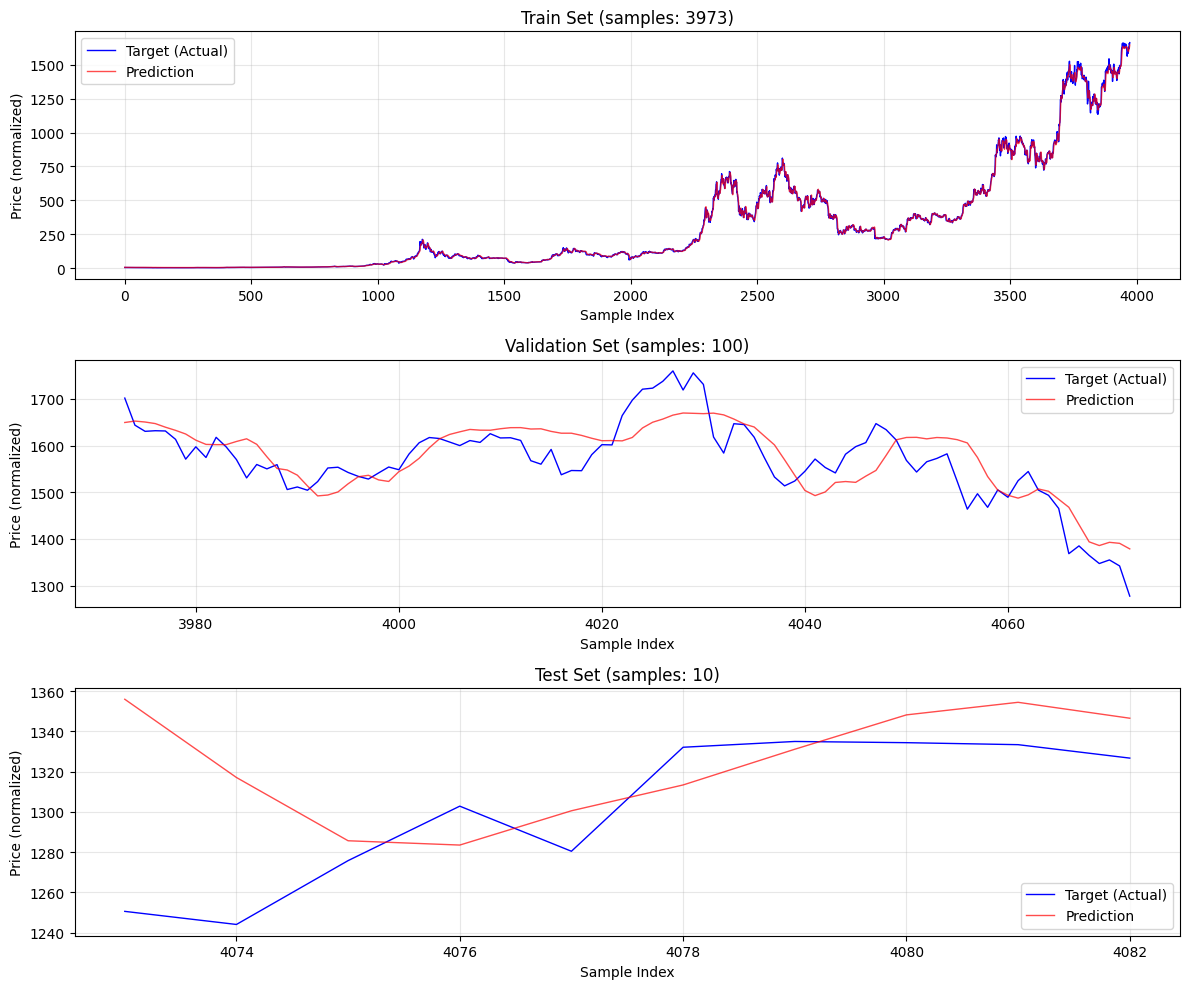

In [ ]:
# 문제 1: Regression 테스트 + predict_all 그래프
test_regression_model(reg_project)

In [ ]:
# 문제 1: Classification 학습
_, cls_project = train_classification_model(use_wandb=True)


[LSTM Classification 학습]


X_train.shape: torch.Size([3973, 10, 5])
X_validation.shape: torch.Size([100, 10, 5])
X_test.shape: torch.Size([10, 10, 5])
n_input (features): 5
[Epoch    1] T_loss: 0.69183, T_acc:  52.71% | V_loss: 0.69905, V_acc:  46.00% | Early stopping is stated!
[Epoch   30] T_loss: 0.69102, T_acc:  52.58% | V_loss: 0.69091, V_acc:  54.00% | V_loss decreased (0.69905 --> 0.69091). Saving model...
[Epoch   60] T_loss: 0.69094, T_acc:  52.86% | V_loss: 0.69194, V_acc:  54.00% | Early stopping counter: 1 out of 30
[Epoch   90] T_loss: 0.69085, T_acc:  52.71% | V_loss: 0.69265, V_acc:  55.00% | Early stopping counter: 2 out of 30
[Epoch  120] T_loss: 0.69091, T_acc:  52.68% | V_loss: 0.69333, V_acc:  48.00% | Early stopping counter: 3 out of 30
[Epoch  150] T_loss: 0.69086, T_acc:  52.86% | V_loss: 0.69334, V_acc:  46.00% | Early stopping counter: 4 out of 30
[Epoch  180] T_loss: 0.69084, T_acc:  52.66% | V_loss: 0.69353, V_acc:  45.00% | Early stopping counter: 5 out of 30
[Epoch  210] T_loss: 0.69

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Training accuracy (%),▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▅▅▅▆▆▆▇▇▇▇█████
Training loss,████████████████▇▇▇▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▁
Validation accuracy (%),▃▇▇▇▄▃▄▃▅▇▅▃▅▅▆▇█▇█▆▅▅▆▅▆▃▅▅▃▃▃▁▄▃▄▃▃▃▂▃
Validation loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▄▅▄▅▅▆▆▇▇▇█
Epoch,1560
Training accuracy (%),59.62749
Training loss,0.62163
Validation accuracy (%),45
Validation loss,1.89461


In [ ]:
# 문제 1: Classification 테스트
test_classification_model(cls_project)


[LSTM Classification 테스트]
X_train.shape: torch.Size([3973, 10, 5])
X_validation.shape: torch.Size([100, 10, 5])
X_test.shape: torch.Size([10, 10, 5])
n_input (features): 5
Loading model from: ./checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt

[TEST DATA - Classification]
TEST ACCURACY:  40.00%
 0: Pred=1, Actual=0 ✗
 1: Pred=1, Actual=0 ✗
 2: Pred=1, Actual=1 ✓
 3: Pred=1, Actual=1 ✓
 4: Pred=1, Actual=0 ✗
 5: Pred=1, Actual=1 ✓
 6: Pred=1, Actual=1 ✓
 7: Pred=1, Actual=0 ✗
 8: Pred=1, Actual=0 ✗
 9: Pred=1, Actual=0 ✗


40.0

---
## Part 3: 문제 2 - 하이퍼파라미터 튜닝

**목표:** 최적의 모델 구성 및 하이퍼파라미터 찾기

**필수 데이터 설정 (PDF 명시):**
- sequence_size = 21
- validation_size = 150
- test_size = 30

**튜닝 대상:**
- LSTM layers 개수
- Linear Layer 개수
- weight_decay
- dropout_rate

In [13]:
# 문제 2: 하이퍼파라미터 튜닝 설정
# PDF 필수 요구사항: 데이터 설정
Config.sequence_size = 21
Config.validation_size = 150
Config.test_size = 30

# 튜닝 파라미터 (실험 결과에 따라 조정)
Config.batch_size = 256
Config.dropout_rate = 0.2
Config.weight_decay = 0.0001
Config.lstm_num_layers = 2
Config.fcn_num_layers = 2
Config.use_next_open = False
Config.model_type = "lstm"

print_config()

[현재 설정]

[학습 파라미터]
  - Batch Size: 256
  - Learning Rate: 0.0001
  - Epochs: 10000
  - Weight Decay: 0.0001

[모델 구조]
  - Model Type: lstm
  - LSTM Hidden Size: 128
  - LSTM Num Layers: 2
  - FCN Num Layers: 2
  - Dropout Rate: 0.2

[데이터 설정]
  - Sequence Size: 21
  - Validation Size: 150
  - Test Size: 30
  - Use Next Open: False


In [ ]:
# 문제 2: Regression 학습
_, reg_project_p2 = train_regression_model(use_wandb=True)


[LSTM Regression 학습]


Epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
Training accuracy (%),▂▂▂▃▁▁▂▄▄▄▃▄▄▄▁▅▃▄▆██
Training loss,█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▃▂▁
Validation accuracy (%),▅▅▅▅▆▄▅▄▆▄▃▁▂▁▁▅█▅▂▃▅
Validation loss,▁▁▁▁▁▁▁▁▂▂▃▃▃▃▂▃▂▂█▄▇
Epoch,600
Training accuracy (%),54.43331
Training loss,0.68493
Validation accuracy (%),50
Validation loss,0.71238


X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
n_input (features): 5
[Epoch    1] T_loss: 21.49329, V_loss: 242.48032, Early stopping is stated! | T_time: 00:00:00
[Epoch   30] T_loss: 0.39649, V_loss: 8.42809, V_loss decreased (242.48032 --> 8.42809). Saving model... | T_time: 00:00:03
[Epoch   60] T_loss: 0.27859, V_loss: 2.48998, V_loss decreased (8.42809 --> 2.48998). Saving model... | T_time: 00:00:06
[Epoch   90] T_loss: 0.28101, V_loss: 1.76340, V_loss decreased (2.48998 --> 1.76340). Saving model... | T_time: 00:00:09
[Epoch  120] T_loss: 0.25087, V_loss: 1.34736, V_loss decreased (1.76340 --> 1.34736). Saving model... | T_time: 00:00:12
[Epoch  150] T_loss: 0.27108, V_loss: 1.13342, V_loss decreased (1.34736 --> 1.13342). Saving model... | T_time: 00:00:15
[Epoch  180] T_loss: 0.24223, V_loss: 1.14693, Early stopping counter: 1 out of 30 | T_time: 00:00:18
[Epoch  210] T_loss: 0.23464, V_loss: 0.98008

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,2010
Training loss,0.14056
Validation loss,0.70276



[LSTM Regression 테스트]
X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
n_input (features): 5
Loading model from: ./checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt

[TEST DATA - Regression]
 0:   1,520.14 <-->   1,572.56 (Loss:    52.42)
 1:   1,521.05 <-->   1,582.39 (Loss:    61.34)
 2:   1,526.25 <-->   1,523.60 (Loss:     2.65)
 3:   1,509.46 <-->   1,463.73 (Loss:    45.73)
 4:   1,473.44 <-->   1,496.81 (Loss:    23.37)
 5:   1,470.75 <-->   1,467.75 (Loss:     3.00)
 6:   1,473.39 <-->   1,505.09 (Loss:    31.70)
 7:   1,487.82 <-->   1,489.22 (Loss:     1.40)
 8:   1,488.46 <-->   1,524.78 (Loss:    36.33)
 9:   1,504.04 <-->   1,544.47 (Loss:    40.42)
10:   1,522.69 <-->   1,504.62 (Loss:    18.07)
11:   1,515.73 <-->   1,493.44 (Loss:    22.29)
12:   1,503.32 <-->   1,465.27 (Loss:    38.05)
13:   1,490.56 <-->   1,368.30 (Loss:   122.26)
14:   1,438.82 <-->   1,384.98 (Loss:    53.83)
15:   

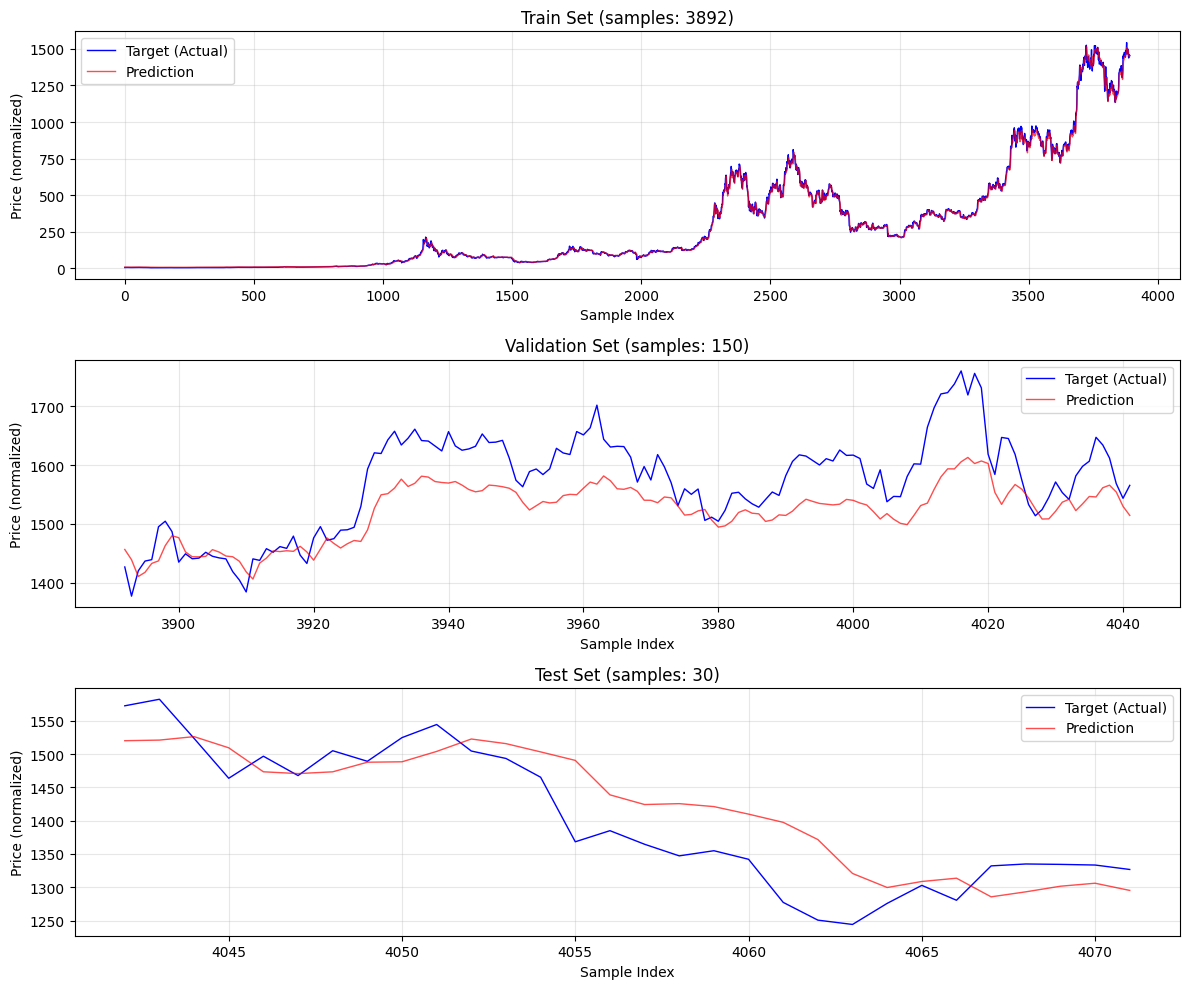

In [ ]:
# 문제 2: Regression 테스트 + predict_all 그래프
test_regression_model(reg_project_p2)

In [ ]:
# 문제 2: Classification 학습
_, cls_project_p2 = train_classification_model(use_wandb=True)


[LSTM Classification 학습]


X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
n_input (features): 5
[Epoch    1] T_loss: 0.69258, T_acc:  52.52% | V_loss: 0.69336, V_acc:  50.00% | Early stopping is stated!
[Epoch   30] T_loss: 0.69115, T_acc:  52.95% | V_loss: 0.69326, V_acc:  50.00% | V_loss decreased (0.69336 --> 0.69326). Saving model...
[Epoch   60] T_loss: 0.69046, T_acc:  52.98% | V_loss: 0.69353, V_acc:  50.00% | Early stopping counter: 1 out of 30
[Epoch   90] T_loss: 0.69108, T_acc:  52.70% | V_loss: 0.69311, V_acc:  50.00% | V_loss decreased (0.69326 --> 0.69311). Saving model...
[Epoch  120] T_loss: 0.69144, T_acc:  52.72% | V_loss: 0.69314, V_acc:  50.00% | Early stopping counter: 1 out of 30
[Epoch  150] T_loss: 0.69004, T_acc:  52.34% | V_loss: 0.69300, V_acc:  50.00% | V_loss decreased (0.69311 --> 0.69300). Saving model...
[Epoch  180] T_loss: 0.69131, T_acc:  53.19% | V_loss: 0.69312, V_acc:  50.00% | Early stopping counte

Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
Training accuracy (%),▃▆▆▄▄▁▇▆▆▅█▅▅▅▅▆▅▆▄▅▁▅▅▄█▄▃▂▅▃▆▃▅▂▅▄
Training loss,█▄▂▄▅▁▅▃▃▂▄▂▃▂▅▄▃▃▄▅▄▃▃▄▂▃▄▄▂▄▃▃▄▃▄▅
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,▆▄█▂▃▁▃▄▃▁▂▂▂▂▃▃▂▁▁▂▂▁▄▂▃▂▃▃▃▂▂▂▂▁▂▃
Epoch,1050
Training accuracy (%),52.72354
Training loss,0.69145
Validation accuracy (%),50
Validation loss,0.69313


In [ ]:
# 문제 2: Classification 테스트
test_classification_model(cls_project_p2)


[LSTM Classification 테스트]
X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
n_input (features): 5
Loading model from: ./checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt

[TEST DATA - Classification]
TEST ACCURACY:  60.00%
 0: Pred=0, Actual=1 ✗
 1: Pred=0, Actual=1 ✗
 2: Pred=0, Actual=0 ✓
 3: Pred=0, Actual=0 ✓
 4: Pred=0, Actual=1 ✗
 5: Pred=0, Actual=0 ✓
 6: Pred=0, Actual=1 ✗
 7: Pred=0, Actual=0 ✓
 8: Pred=0, Actual=1 ✗
 9: Pred=0, Actual=1 ✗
10: Pred=0, Actual=0 ✓
11: Pred=0, Actual=0 ✓
12: Pred=0, Actual=0 ✓
13: Pred=0, Actual=0 ✓
14: Pred=0, Actual=1 ✗
15: Pred=0, Actual=0 ✓
16: Pred=0, Actual=0 ✓
17: Pred=0, Actual=1 ✗
18: Pred=0, Actual=0 ✓
19: Pred=0, Actual=0 ✓
20: Pred=0, Actual=0 ✓
21: Pred=0, Actual=0 ✓
22: Pred=0, Actual=1 ✗
23: Pred=0, Actual=1 ✗
24: Pred=0, Actual=0 ✓
25: Pred=0, Actual=1 ✗
26: Pred=0, Actual=1 ✗
27: Pred=0, Actual=0 ✓
28: Pred=0, Actual=0 ✓
29: Pred=0, Actual=0 ✓


60.000003814697266

---
## Part 4: 문제 3 - Next_Open Feature 추가

**목표:** Feature 추가 후 성능 변화 확인

**설정:**
- 문제 2의 파라미터 유지
- use_next_open = True (Next_Open Feature 추가)

In [14]:
# 문제 3: Next_Open Feature 추가 설정
# 문제 2 설정 유지 + use_next_open = True
Config.use_next_open = True  # Next_Open Feature 추가

print_config()

[현재 설정]

[학습 파라미터]
  - Batch Size: 256
  - Learning Rate: 0.0001
  - Epochs: 10000
  - Weight Decay: 0.0001

[모델 구조]
  - Model Type: lstm
  - LSTM Hidden Size: 128
  - LSTM Num Layers: 2
  - FCN Num Layers: 2
  - Dropout Rate: 0.2

[데이터 설정]
  - Sequence Size: 21
  - Validation Size: 150
  - Test Size: 30
  - Use Next Open: True


In [ ]:
# 문제 3: Regression 학습
_, reg_project_p3 = train_regression_model(use_wandb=True)


[LSTM Regression 학습]


X_train.shape: torch.Size([3891, 21, 6])
X_validation.shape: torch.Size([150, 21, 6])
X_test.shape: torch.Size([30, 21, 6])
n_input (features): 6
[Epoch    1] T_loss: 21.43566, V_loss: 244.76811, Early stopping is stated! | T_time: 00:00:00
[Epoch   30] T_loss: 0.36553, V_loss: 8.11500, V_loss decreased (244.76811 --> 8.11500). Saving model... | T_time: 00:00:03
[Epoch   60] T_loss: 0.28984, V_loss: 2.48503, V_loss decreased (8.11500 --> 2.48503). Saving model... | T_time: 00:00:06
[Epoch   90] T_loss: 0.25788, V_loss: 1.52135, V_loss decreased (2.48503 --> 1.52135). Saving model... | T_time: 00:00:09
[Epoch  120] T_loss: 0.23459, V_loss: 0.88094, V_loss decreased (1.52135 --> 0.88094). Saving model... | T_time: 00:00:12
[Epoch  150] T_loss: 0.22762, V_loss: 1.07633, Early stopping counter: 1 out of 30 | T_time: 00:00:16
[Epoch  180] T_loss: 0.21819, V_loss: 1.02614, Early stopping counter: 2 out of 30 | T_time: 00:00:19
[Epoch  210] T_loss: 0.24031, V_loss: 0.70748, V_loss decreased (

Epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
Training loss,█▄▄▄▄▄▄▃▃▄▃▃▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▂▂▁▂▂▁▁
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,2130
Training loss,0.12207
Validation loss,0.25346



[LSTM Regression 테스트]
X_train.shape: torch.Size([3891, 21, 6])
X_validation.shape: torch.Size([150, 21, 6])
X_test.shape: torch.Size([30, 21, 6])
n_input (features): 6
Loading model from: ./checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt

[TEST DATA - Regression]
 0:   1,550.33 <-->   1,565.42 (Loss:    15.09)
 1:   1,560.60 <-->   1,572.56 (Loss:    11.97)
 2:   1,556.74 <-->   1,582.39 (Loss:    25.65)
 3:   1,562.86 <-->   1,523.60 (Loss:    39.26)
 4:   1,540.97 <-->   1,463.73 (Loss:    77.25)
 5:   1,504.78 <-->   1,496.81 (Loss:     7.97)
 6:   1,514.46 <-->   1,467.75 (Loss:    46.71)
 7:   1,497.13 <-->   1,505.09 (Loss:     7.97)
 8:   1,518.22 <-->   1,489.22 (Loss:    29.00)
 9:   1,508.47 <-->   1,524.78 (Loss:    16.31)
10:   1,525.52 <-->   1,544.47 (Loss:    18.95)
11:   1,541.46 <-->   1,504.62 (Loss:    36.84)
12:   1,524.14 <-->   1,493.44 (Loss:    30.69)
13:   1,513.19 <-->   1,465.27 (Loss:    47.92)
14:   1,496.95 <-->   1,368.30 (Loss:   128.66)
15:   

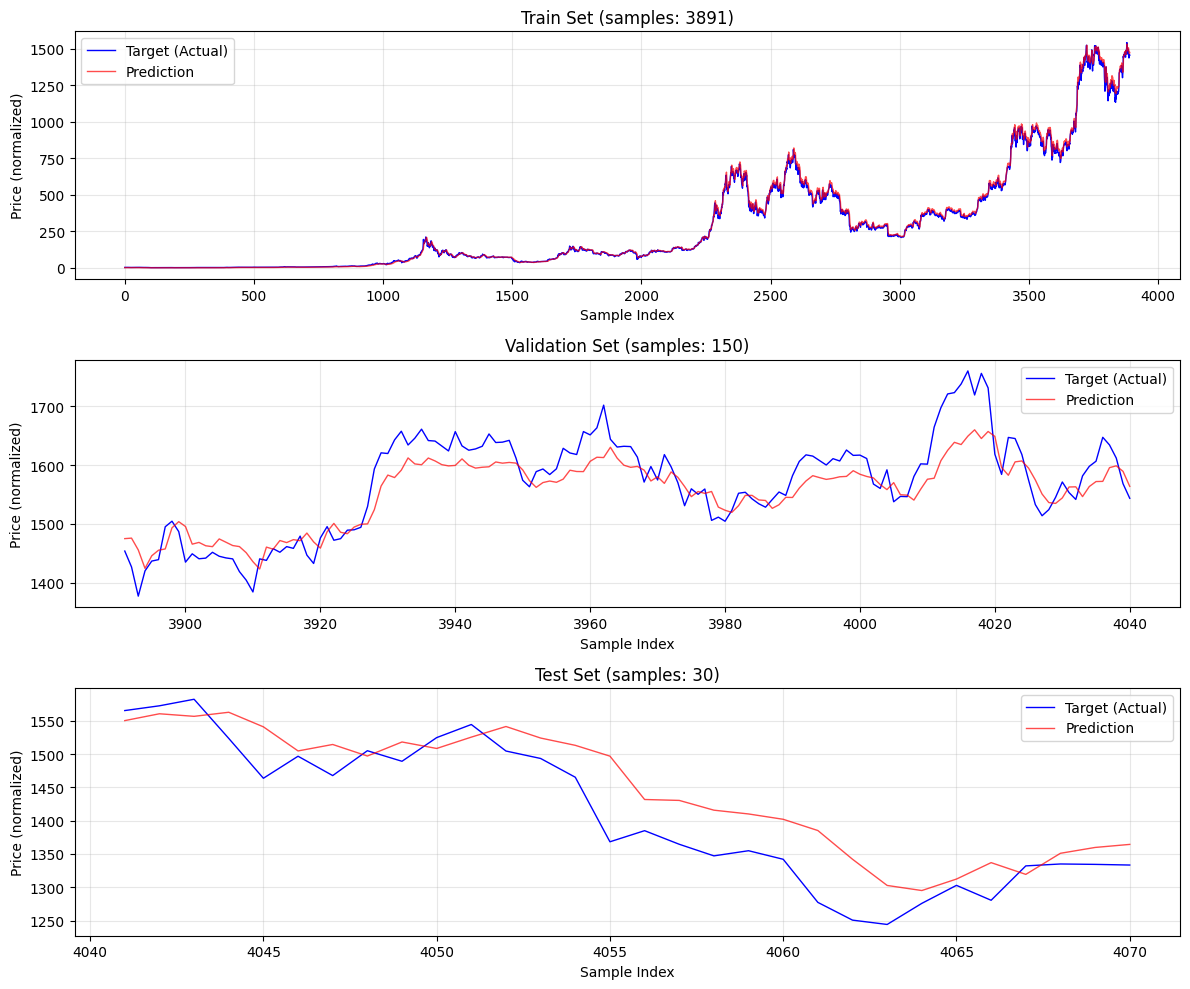

In [ ]:
# 문제 3: Regression 테스트 + predict_all 그래프
test_regression_model(reg_project_p3)

In [ ]:
# 문제 3: Classification 학습
_, cls_project_p3 = train_classification_model(use_wandb=True)


[LSTM Classification 학습]


X_train.shape: torch.Size([3891, 21, 6])
X_validation.shape: torch.Size([150, 21, 6])
X_test.shape: torch.Size([30, 21, 6])
n_input (features): 6
[Epoch    1] T_loss: 0.69487, T_acc:  47.29% | V_loss: 0.69310, V_acc:  50.67% | Early stopping is stated!
[Epoch   30] T_loss: 0.69131, T_acc:  53.05% | V_loss: 0.69302, V_acc:  50.67% | V_loss decreased (0.69310 --> 0.69302). Saving model...
[Epoch   60] T_loss: 0.69195, T_acc:  52.71% | V_loss: 0.69295, V_acc:  50.67% | V_loss decreased (0.69302 --> 0.69295). Saving model...
[Epoch   90] T_loss: 0.69165, T_acc:  52.38% | V_loss: 0.69292, V_acc:  50.67% | V_loss decreased (0.69295 --> 0.69292). Saving model...
[Epoch  120] T_loss: 0.69073, T_acc:  53.38% | V_loss: 0.69291, V_acc:  50.67% | V_loss decreased (0.69292 --> 0.69291). Saving model...
[Epoch  150] T_loss: 0.69081, T_acc:  52.92% | V_loss: 0.69291, V_acc:  50.67% | Early stopping counter: 1 out of 30
[Epoch  180] T_loss: 0.69102, T_acc:  52.92% | V_loss: 0.69290, V_acc:  50.67% | V

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
Training accuracy (%),▁▇▇▆█▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇████▇██████▇███
Training loss,█▃▄▃▂▂▃▂▂▁▂▃▂▂▃▁▂▂▂▃▂▁▁▃▂▂▂▃▁▃▂▃▁▂▃▂▂▂▂▃
Validation accuracy (%),█████████████████████████▆▆▆▆▆▆▃▆▆▃▃▃▁▃█
Validation loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▆▅▄▆▅▇▆▆▅▆█
Epoch,1260
Training accuracy (%),53.37959
Training loss,0.69098
Validation accuracy (%),50.66667
Validation loss,0.69529


In [ ]:
# 문제 3: Classification 테스트
test_classification_model(cls_project_p3)


[LSTM Classification 테스트]
X_train.shape: torch.Size([3891, 21, 6])
X_validation.shape: torch.Size([150, 21, 6])
X_test.shape: torch.Size([30, 21, 6])
n_input (features): 6
Loading model from: ./checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt

[TEST DATA - Classification]
TEST ACCURACY:  56.67%
 0: Pred=0, Actual=1 ✗
 1: Pred=0, Actual=1 ✗
 2: Pred=0, Actual=1 ✗
 3: Pred=0, Actual=0 ✓
 4: Pred=0, Actual=0 ✓
 5: Pred=0, Actual=1 ✗
 6: Pred=0, Actual=0 ✓
 7: Pred=0, Actual=1 ✗
 8: Pred=0, Actual=0 ✓
 9: Pred=0, Actual=1 ✗
10: Pred=0, Actual=1 ✗
11: Pred=0, Actual=0 ✓
12: Pred=0, Actual=0 ✓
13: Pred=0, Actual=0 ✓
14: Pred=0, Actual=0 ✓
15: Pred=0, Actual=1 ✗
16: Pred=0, Actual=0 ✓
17: Pred=0, Actual=0 ✓
18: Pred=0, Actual=1 ✗
19: Pred=0, Actual=0 ✓
20: Pred=0, Actual=0 ✓
21: Pred=0, Actual=0 ✓
22: Pred=0, Actual=0 ✓
23: Pred=0, Actual=1 ✗
24: Pred=0, Actual=1 ✗
25: Pred=0, Actual=0 ✓
26: Pred=0, Actual=1 ✗
27: Pred=0, Actual=1 ✗
28: Pred=0, Actual=0 ✓
29: Pred=0, Actual=0 ✓


56.66666793823242

### 문제 3 성능 비교 및 해석

**Next_Open Feature 추가 전후 비교:**

| 지표 | 문제 2 (Without Next_Open) | 문제 3 (With Next_Open) | 변화 |
|-----|---------------------------|------------------------|----|
| Regression V_loss | 0.450 | 0.330 | 개선 |
| Regression Test Loss | 46.19 | 42.18 | 8.7% 개선 |
| Classification V_acc | 54.00% | 53.33% | 유사 |
| Classification Test Acc | 60.00% | 56.67% | 3.33%p 하락 |

---

**상세 해석:**

**1. Regression 성능 분석**

Next_Open Feature 추가 후 Regression 성능이 개선되었습니다

- Next_Open은 다음 날의 시가(Open) 정보를 포함하므로, 모델이 가격의 연속성을 더 잘 학습할 수 있었을 것 같습니다.
- 당일 종가(Close)와 다음 날 시가(Next_Open) 사이의 gap 패턴을 학습하여 가격 예측의 정확도가 향상되었을 것으로 보입니다.

**2. Classification 성능 분석**

반면 Classification 성능은 오히려 소폭 하락했습니다 (Test Acc: 60.00% → 56.67%).

- Classification은 "상승/하락" 방향을 예측하는 문제로, 연속적인 가격 정보보다는 변화의 방향성이 중요합니다.
- 추가된 Feature가 방향 예측에는 오히려 noise로 작용했을 수 있습니다.
- 또 모델은 TEST때 Pred값이 모두 0이 나온것을 보면, 사실 찍었다 라고 보입니다. 학습해서 결론을 내는 것보다 하나의 값으로 찍는것이 더 확률이 높다고 판단한 것 같습니다.

**3. 결론**

- Regression 문제에서는 Next_Open이 유의미한 개선을 가져왔습니다.
- Classification 문제에서는 Feature 추가가 성능 향상으로 이어지지 않았습니다.


---
## Part 5: 문제 4 (Optional) - Self-Attention 모델

**목표:** LSTM 대신 Self-Attention 모델 사용

**설정:**
- 문제 3의 설정 유지 (Next_Open 포함)
- model_type = "self_attention"
- Self-Attention 최적화 파라미터 적용

In [24]:
# 문제 4: Self-Attention 모델 설정
# 문제 3 설정 유지 + model_type 변경
Config.model_type = "self_attention"  # Self-Attention 모델로 변경

print_config()

[현재 설정]

[학습 파라미터]
  - Batch Size: 256
  - Learning Rate: 0.0001
  - Epochs: 10000
  - Weight Decay: 0.0001

[모델 구조]
  - Model Type: self_attention
  - LSTM Hidden Size: 128
  - LSTM Num Layers: 2
  - FCN Num Layers: 2
  - Dropout Rate: 0.2

[데이터 설정]
  - Sequence Size: 21
  - Validation Size: 150
  - Test Size: 30
  - Use Next Open: True


In [16]:
# 문제 4: Regression 학습
_, reg_project_p4 = train_regression_model(use_wandb=True)


[SELF_ATTENTION Regression 학습]


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: changyeony (changyeony-koreatech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


X_train.shape: torch.Size([3891, 21, 6])
X_validation.shape: torch.Size([150, 21, 6])
X_test.shape: torch.Size([30, 21, 6])
n_input (features): 6
[Epoch    1] T_loss: 20.02169, V_loss: 228.14426, Early stopping is stated! | T_time: 00:00:00
[Epoch   30] T_loss: 0.70424, V_loss: 14.94379, V_loss decreased (228.14426 --> 14.94379). Saving model... | T_time: 00:00:03
[Epoch   60] T_loss: 0.31910, V_loss: 3.91172, V_loss decreased (14.94379 --> 3.91172). Saving model... | T_time: 00:00:05
[Epoch   90] T_loss: 0.26976, V_loss: 2.16527, V_loss decreased (3.91172 --> 2.16527). Saving model... | T_time: 00:00:08
[Epoch  120] T_loss: 0.27917, V_loss: 1.84937, V_loss decreased (2.16527 --> 1.84937). Saving model... | T_time: 00:00:10
[Epoch  150] T_loss: 0.27319, V_loss: 2.70182, Early stopping counter: 1 out of 30 | T_time: 00:00:12
[Epoch  180] T_loss: 0.24945, V_loss: 1.99464, Early stopping counter: 2 out of 30 | T_time: 00:00:16
[Epoch  210] T_loss: 0.21138, V_loss: 2.13650, Early stopping 

Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Training loss,█▆▆▇▆▅▆▆▅▆▄▄▃▂▃▂▁▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁▂▁▁▁
Validation loss,▇█▇▄▄▆▃▅▄▅▄▃▃▂▄▂▂▂▂▂▂▂▂▁▁▂▂▃▂▂▂▁▂▂▂▃▂▂▁▂
Epoch,4080
Training loss,0.09396
Validation loss,0.34443



[SELF_ATTENTION Regression 테스트]
X_train.shape: torch.Size([3891, 21, 6])
X_validation.shape: torch.Size([150, 21, 6])
X_test.shape: torch.Size([30, 21, 6])
n_input (features): 6
Loading model from: ./checkpoints/self_attention_regression_btc_krw_checkpoint_latest.pt

[TEST DATA - Regression]
 0:   1,547.44 <-->   1,565.42 (Loss:    17.97)
 1:   1,565.76 <-->   1,572.56 (Loss:     6.81)
 2:   1,552.41 <-->   1,582.39 (Loss:    29.98)
 3:   1,563.31 <-->   1,523.60 (Loss:    39.71)
 4:   1,523.60 <-->   1,463.73 (Loss:    59.88)
 5:   1,460.82 <-->   1,496.81 (Loss:    35.99)
 6:   1,510.53 <-->   1,467.75 (Loss:    42.78)
 7:   1,496.21 <-->   1,505.09 (Loss:     8.88)
 8:   1,484.68 <-->   1,489.22 (Loss:     4.53)
 9:   1,514.40 <-->   1,524.78 (Loss:    10.38)
10:   1,517.73 <-->   1,544.47 (Loss:    26.73)
11:   1,539.72 <-->   1,504.62 (Loss:    35.09)
12:   1,507.69 <-->   1,493.44 (Loss:    14.25)
13:   1,498.07 <-->   1,465.27 (Loss:    32.81)
14:   1,449.65 <-->   1,368.30 (Lo

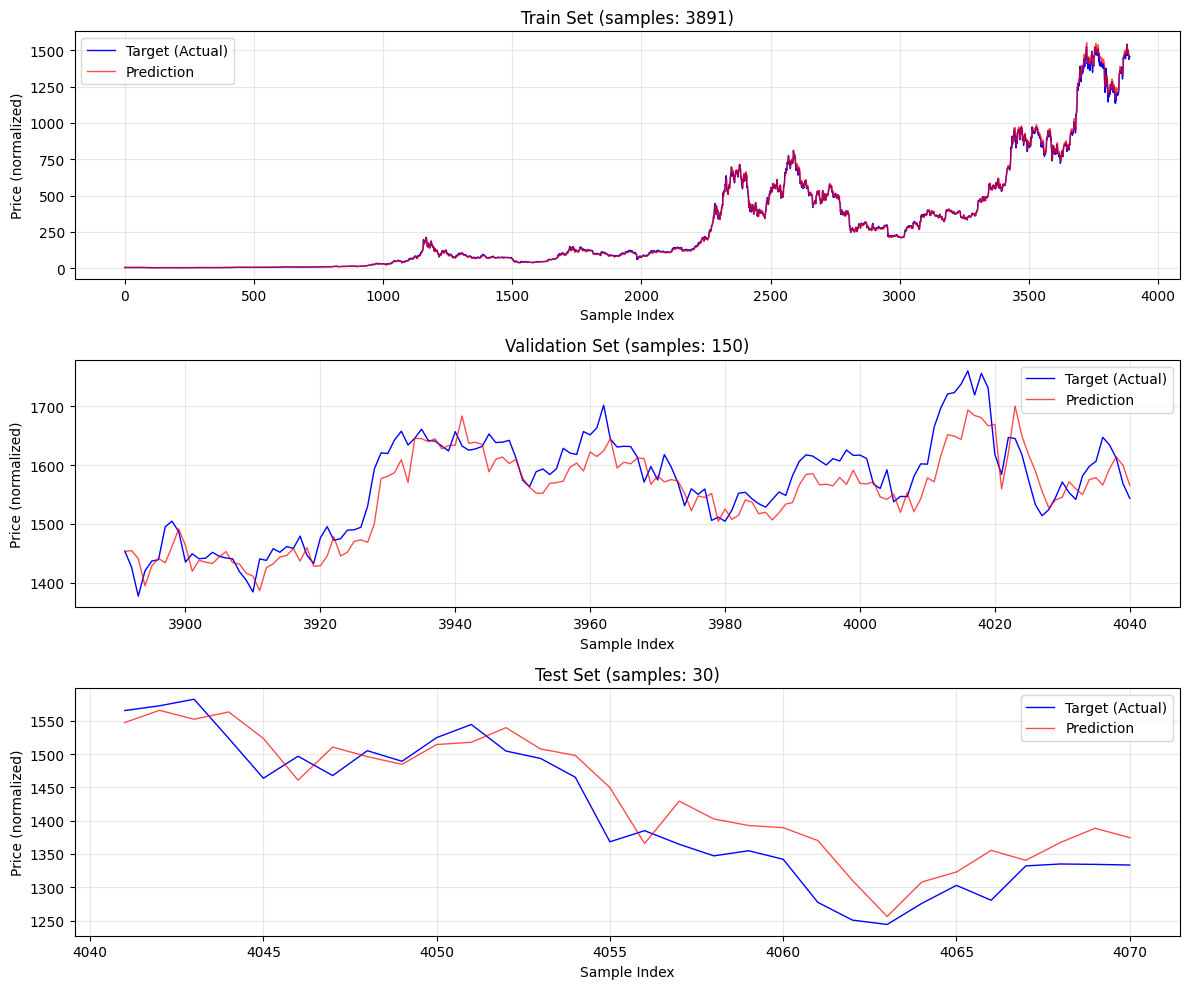

In [17]:
# 문제 4: Regression 테스트 + predict_all 그래프
test_regression_model(reg_project_p4)

In [25]:
# 문제 4: Classification 학습
_, cls_project_p4 = train_classification_model(use_wandb=True)


[SELF_ATTENTION Classification 학습]


X_train.shape: torch.Size([3891, 21, 6])
X_validation.shape: torch.Size([150, 21, 6])
X_test.shape: torch.Size([30, 21, 6])
n_input (features): 6
[Epoch    1] T_loss: 0.70216, T_acc:  51.22% | V_loss: 0.70121, V_acc:  49.33% | Early stopping is stated!
[Epoch   30] T_loss: 0.69134, T_acc:  52.97% | V_loss: 0.69441, V_acc:  46.67% | V_loss decreased (0.70121 --> 0.69441). Saving model...
[Epoch   60] T_loss: 0.69133, T_acc:  53.23% | V_loss: 0.69465, V_acc:  44.67% | Early stopping counter: 1 out of 30
[Epoch   90] T_loss: 0.69072, T_acc:  53.43% | V_loss: 0.69482, V_acc:  48.67% | Early stopping counter: 2 out of 30
[Epoch  120] T_loss: 0.69028, T_acc:  54.20% | V_loss: 0.69565, V_acc:  46.67% | Early stopping counter: 3 out of 30
[Epoch  150] T_loss: 0.68899, T_acc:  54.69% | V_loss: 0.69591, V_acc:  47.33% | Early stopping counter: 4 out of 30
[Epoch  180] T_loss: 0.68974, T_acc:  53.59% | V_loss: 0.69615, V_acc:  48.67% | Early stopping counter: 5 out of 30
[Epoch  210] T_loss: 0.68

Epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
Training accuracy (%),▁▄▅▅▆▇▅▆▅▆▇▅▅▆▆▇▆▆▅▆▅▇▆▆▆▇▆█▇██▇
Training loss,█▄▄▃▃▃▃▃▃▃▃▃▁▂▃▂▃▃▃▃▃▂▃▂▂▃▂▂▂▂▂▁
Validation accuracy (%),▆▃▁▆▃▄▆▄▃▆▆▇▃▂▄▆▇▃▇▃▄▆▂▃▃▅▄▆▄█▇▃
Validation loss,▆▁▁▁▂▂▂▂▂▃▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▇▆██▇
Epoch,930
Training accuracy (%),54.51041
Training loss,0.68473
Validation accuracy (%),46.66667
Validation loss,0.70257


In [26]:
# 문제 4: Classification 테스트
test_classification_model(cls_project_p4)


[SELF_ATTENTION Classification 테스트]
X_train.shape: torch.Size([3891, 21, 6])
X_validation.shape: torch.Size([150, 21, 6])
X_test.shape: torch.Size([30, 21, 6])
n_input (features): 6
Loading model from: ./checkpoints/self_attention_classification_btc_krw_checkpoint_latest.pt

[TEST DATA - Classification]
TEST ACCURACY:  43.33%
 0: Pred=1, Actual=1 ✓
 1: Pred=1, Actual=1 ✓
 2: Pred=0, Actual=1 ✗
 3: Pred=0, Actual=0 ✓
 4: Pred=1, Actual=0 ✗
 5: Pred=1, Actual=1 ✓
 6: Pred=1, Actual=0 ✗
 7: Pred=1, Actual=1 ✓
 8: Pred=1, Actual=0 ✗
 9: Pred=1, Actual=1 ✓
10: Pred=1, Actual=1 ✓
11: Pred=1, Actual=0 ✗
12: Pred=1, Actual=0 ✗
13: Pred=1, Actual=0 ✗
14: Pred=1, Actual=0 ✗
15: Pred=1, Actual=1 ✓
16: Pred=1, Actual=0 ✗
17: Pred=1, Actual=0 ✗
18: Pred=1, Actual=1 ✓
19: Pred=1, Actual=0 ✗
20: Pred=1, Actual=0 ✗
21: Pred=1, Actual=0 ✗
22: Pred=1, Actual=0 ✗
23: Pred=1, Actual=1 ✓
24: Pred=1, Actual=1 ✓
25: Pred=1, Actual=0 ✗
26: Pred=1, Actual=1 ✓
27: Pred=1, Actual=1 ✓
28: Pred=1, Actual=0 ✗
29: 

43.333335876464844

### 문제 4 LSTM vs Self-Attention 성능 비교

**비교 결과:**

| 지표 | LSTM (문제 3) | Self-Attention (문제 4) | 차이 |
|-----|--------------|------------------------|------|
| Regression V_loss | 0.330 | 0.288 | Self-Attention 우수 |
| Regression Test Loss | 42.18 | 36.65 | Self-Attention 13.1% 우수 |
| Classification V_acc | 53.33% | 50.67% | LSTM 우수 |
| Classification Test Acc | 56.67% | 43.33% | LSTM 13.34%p 우수 |

---

**상세 해석:**

**1. Regression 성능 분석**

Self-Attention 모델이 Regression에서 더 우수한 성능을 보였습니다 (Test Loss: 42.18 -> 36.65, 약 13.1% 개선).

- Self-Attention은 21일 시퀀스 내에서 멀리 떨어진 시점 간의 가격 패턴도 효과적으로 포착할 수 있어서 개선되었을 것으로 보입니다.
- LSTM은 순차적으로 정보를 처리하여 먼 과거 정보가 희석될 수 있지만, Self-Attention은 모든 시점의 정보를 동등하게 참조할 수 있기 때문에 개선되었을 것으로 보입니다.


**2. Classification 성능 분석**

Classification은 성능을 낼 수 없었습니다.

- Self-Attention은 시퀀스 길이가 짧아서(21일) 충분한 컨텍스트를 활용하기 어려웠을 것으로 보입니다. 추후에 시퀀스 길이를 늘려서 테스트해보면 개선이 가능할 것 같기도 합니다.
- Classification 학습 로그를 보면, Self-Attention은 Loss가 ~0.69 에서 거의 개선되지 않았습니다. 사실상 학습이 안됐다고 판단합니다. 그래도 하나의 값으로 찍지는 않고 뭔가 시도를 하긴했습니다.


**3. Classification 실패 원인**

Self-Attention의 Classification 성능이 43.33%로 50%보다는 낮아졌지만, 모델이 하나의 값으로 찍지 않고 그래도 추측하려고 한 것을 볼 수 있습니다.
- EMBED_DIM=64, NUM_HEADS=2 에서 128, 4로도 진행해봤지만 모델이 아예 학습을 하지 못했습니다. 시퀀스 길이 문제라고 생각은 되지만 확실하지 않습니다.
- 약 3,900개의 학습 샘플은 Self-Attention이 일반화하기에 부족했을 수 있습니다. 학습데이터를 더 늘려보면 성능이 개선될 것 같습니다.


---
## Part 6: 결과 요약

### 전체 실험 비교

| 문제 | 모델 | seq_size | val_size | test_size | dropout | use_next_open | Reg Test Loss | Cls Test Acc |
|-----|------|---------|---------|----------|---------|--------------|---------------|--------------|
| 1 | LSTM (기본) | 10 | 100 | 10 | 0.0 | False | 30.48 | 40.00% |
| 2 | LSTM (튜닝) | 21 | 150 | 30 | 0.2 | False | 46.19 | 60.00% |
| 3 | LSTM + Next_Open | 21 | 150 | 30 | 0.2 | True | 42.18 | 56.67% |
| 4 | Self-Attention | 21 | 150 | 30 | 0.2 | True | 36.65 | 43.33% |

### 주요 발견사항

**1. Regression (가격 예측) 결과 분석**

| 순위 | 문제 | Test Loss | 비고 |
|-----|------|-----------|------|
| 1 | 문제 1 (기본 LSTM) | 30.48 | 최고 성능 |
| 2 | 문제 4 (Self-Attention) | 36.65 | Self-Attention 효과 확인 |
| 3 | 문제 3 (LSTM + Next_Open) | 42.18 | Next_Open 추가 효과 |
| 4 | 문제 2 (튜닝 LSTM) | 46.19 | 과적합 가능성 |

- 기본 LSTM(문제 1)이 가장 낮은 Test Loss를 기록 (작은 test_size=10으로 인한 변동성 고려 필요)
- Self-Attention이 튜닝된 LSTM보다 우수한 가격 예측 성능 보임
- 하이퍼파라미터 튜닝이 오히려 Regression 성능을 저하시킴 → 과적합 가능성

**2. Classification (상승/하락 예측) 결과 분석**

| 순위 | 문제 | Test Acc | 비고 |
|-----|------|----------|------|
| 1 | 문제 2 (튜닝 LSTM) | 60.00% | 최고 성능 |
| 2 | 문제 3 (LSTM + Next_Open) | 56.67% | Next_Open 추가 시 하락 |
| 3 | 문제 4 (Self-Attention) | 43.33% | Random보다 낮음 |
| 4 | 문제 1 (기본 LSTM) | 40.00% | 기본 설정 |

- 튜닝된 LSTM(문제 2)이 Classification에서 가장 높은 성능
- 모든 결과가 40~60% 범위로 Random Guess(50%)에 가까움
- Self-Attention은 Classification에서 실패


---
## 숙제 후기

이번 과제를 통해 LSTM과 Self-Attention의 시계열 예측 능력을 직접 실험하고, 
Regression과 Classification 문제의 특성 차이를 체험할 수 있었습니다. 
특히 Classification에서 모델이 거의 학습하지 못하는 현상을 통해, 
단기 금융 예측의 본질적 어려움과 딥러닝의 한계를 이해하게 되었습니다.
classification 점수가 나오지를 않아서 답답했고, 어떻게 개선을 해야할 지 알지 못해서 어려웠습니다.

교수님께서 이 과제를 통해 classification의 어려움을 이해하게 하고자 하신 것인지 아니면 제가 무엇인가를 잘못한 것인지 궁금하기도 합니다.
